In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
from fishchips.experiments import Experiment, CMB_Primary
from fishchips.cosmo import Observables
import fishchips.util

import numpy as np
import matplotlib.pyplot as plt

In this notebook, we extend the Galaxy Lensing notebook to include cross-correlated lensing planes. All this really requires is expanding the Fisher matrix to include these different redshift bins, and associated cross-correlations.

In [3]:
# create an Observables object to store information for derivatives
obs_tom = Observables(parameters= ['A_s', 'omega_cdm', 'm_ncdm'],
                  fiducial=[2.1e-9, 0.12,  0.06],
                  left=[2.0e-9, 0.10, 0.0],
                  right=[2.2e-9, 0.14, 0.12])

In [4]:
# generate a template CLASS python wrapper configuration
classy_template_tom = {'output': 'tCl pCl lCl sCl mPk rCl',
                   'l_max_scalars': 5000,
                   'lensing': 'yes',
                   'N_ncdm': 1,
                   'non linear': 'halofit',
                   'selection': 'dirac',
                   'selection_mean': '0.5, 1.0, 1.5, 2.0, 2.5',
                   'non_diagonal': 4,
                   'l_max_lss' : 5000,
                    'accurate_lensing':1
                  }
# classy_template.update(fishchips.util.PRECISE_CLASS_DICT)
# add in the fiducial values too
classy_template_tom.update(dict(zip(obs_tom.parameters, obs_tom.fiducial)))

The only thing in the setup that has changed is the configuration lines,
```python
'selection_mean': '0.5, 1.0, 1.5, 2.0, 2.5',
'non_diagonal': 4,
```
which asks CLASS to compute the lensing potential in five different redshift source planes, and also compute the cross-correlations so we have access to the full covariance matrix.

In [5]:
# generate the fiducial cosmology
obs_tom.compute_cosmo(key='CLASS_fiducial', classy_dict=classy_template_tom)

# generate an observables dictionary, looping over parameters
for par, par_left, par_right in zip(obs_tom.parameters, obs_tom.left, obs_tom.right):
    classy_left = classy_template_tom.copy()
    classy_left[par] = par_left
    classy_right = classy_template_tom.copy()
    classy_right[par] = par_right
    # pass the dictionaries full of configurations to get computed
    obs_tom.compute_cosmo(key=par + '_CLASS_left', classy_dict=classy_left)
    obs_tom.compute_cosmo(key=par + '_CLASS_right', classy_dict=classy_right)

## Test Plot
First, we will examine the `density_cl()` dictionary.

In [6]:
obs_tom.cosmos['CLASS_fiducial'].density_cl()

{'ell': array([   0,    1,    2, ..., 4998, 4999, 5000]),
 'll': {0: array([0.00000000e+00, 0.00000000e+00, 2.48396898e-09, ...,
         3.45627329e-26, 3.45290208e-26, 3.44952063e-26]),
  1: array([0.00000000e+00, 0.00000000e+00, 2.99447587e-09, ...,
         6.15133846e-26, 6.14565590e-26, 6.13995413e-26]),
  2: array([0.00000000e+00, 0.00000000e+00, 3.18908920e-09, ...,
         7.02585863e-26, 7.01942605e-26, 7.01297137e-26]),
  3: array([0.00000000e+00, 0.00000000e+00, 3.29043732e-09, ...,
         7.45574141e-26, 7.44894014e-26, 7.44211536e-26]),
  4: array([0.00000000e+00, 0.00000000e+00, 3.35257714e-09, ...,
         7.71151698e-26, 7.70449635e-26, 7.69745136e-26]),
  5: array([0.00000000e+00, 0.00000000e+00, 3.81958206e-09, ...,
         2.05087198e-25, 2.04918456e-25, 2.04749014e-25]),
  6: array([0.00000000e+00, 0.00000000e+00, 4.16813777e-09, ...,
         2.75074934e-25, 2.74853136e-25, 2.74630386e-25]),
  7: array([0.00000000e+00, 0.00000000e+00, 4.35660835e-09, ...,
   

The CLASS python wrapper documentation says this about this dictionary,

> Array that contains the list (in this order) of self correlation of
> 1st bin, then successive correlations (set by non_diagonal) to the
> following bins, then self correlation of 2nd bin, etc. The array
> starts at index_ct_dd.

It looks like this is basically the upper-triangle of the covariance matrix, written top-to-bottom and left-to-right. We'll write a $\mathbf{C}_{\ell}$ matrix utility to extract this matrix from the dictionary.

In [7]:
def get_kcov(cosmo, nbins, non_diagonal, verbose=False):
    """
    Generate a WL convergence covariance matrix from a CLASS dictionary.
    
    There's a for loop in here, but this function gets run once per CLASS
    call, so I think the performance of the function doesn't really matter.
    
    Parameters
    ----------
        cosmo (CLASS wrapper object) : stored, computed cosmology
        nbins (integer) : number of redshift bins
        non_diagonal (integer) number of non-diagonal bins
    """
    dcl = cosmo.density_cl()
    ell = dcl['ell']
    pref = 0.25 * (ell+2) * (ell+1) * (ell) * (ell-1)
    cov_mat = np.zeros((nbins, nbins, len(ell)))
    debug_mat = np.zeros((nbins, nbins))
    counter = 0
    for bin_index in range(nbins):
        for diag_index in range(min(nbins-bin_index, non_diagonal+1)):
            debug_mat[bin_index, bin_index+diag_index] = counter
            debug_mat[bin_index+diag_index, bin_index] = counter
            
            # we multiply the prefactors to use the lensing convergence instead 
            # of the lensing potential
            cov_mat[bin_index, bin_index+diag_index, :] = pref * dcl['ll'][counter]
            cov_mat[bin_index+diag_index, bin_index, :] = pref * dcl['ll'][counter]
            
            counter += 1
    
    # if verbose is set, we produce a matrix which refers to the CLASS 
    # cosmo index, for each array cross section.
    if(verbose):
        print('debug matrix:\n', debug_mat)
    return cov_mat

example_kcov = get_kcov(obs_tom.cosmos['CLASS_fiducial'], nbins=5, non_diagonal=4, verbose=True)

debug matrix:
 [[ 0.  1.  2.  3.  4.]
 [ 1.  5.  6.  7.  8.]
 [ 2.  6.  9. 10. 11.]
 [ 3.  7. 10. 12. 13.]
 [ 4.  8. 11. 13. 14.]]


We'll plot just the fiducial $P_{\kappa}$ for this notebook, showing the different signal curves for each redshift.

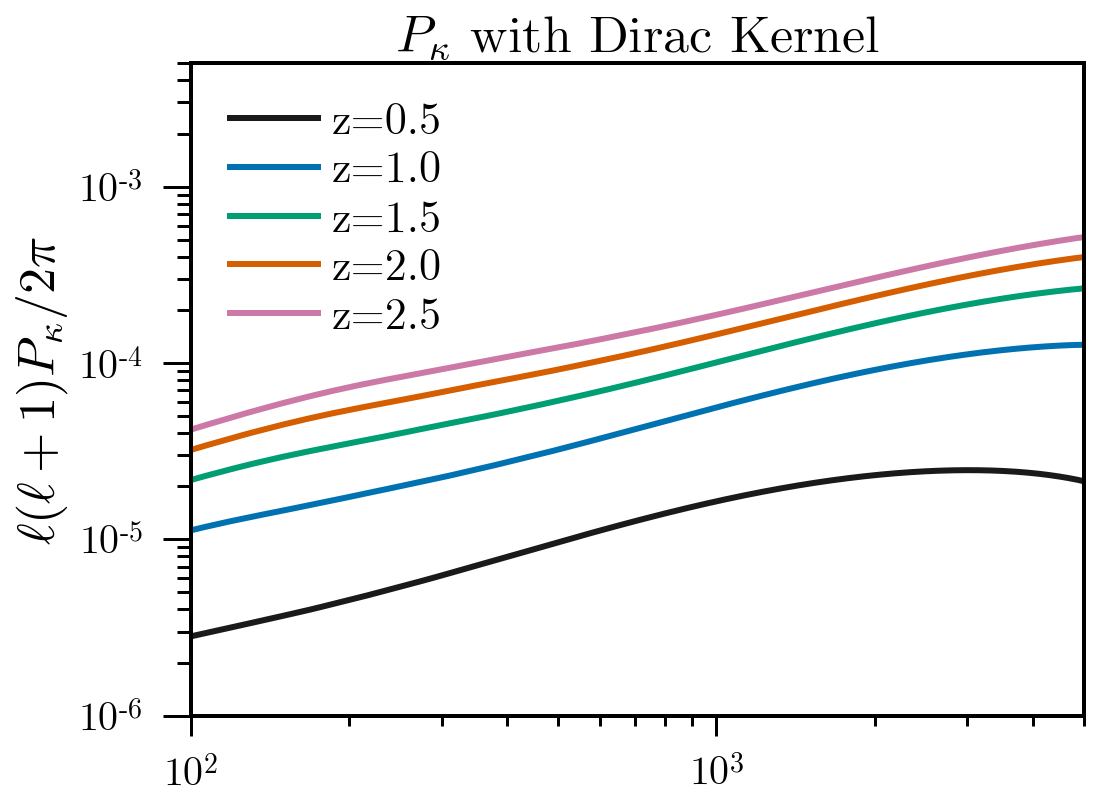

In [8]:
plt.figure(figsize=(8,6))

ell = np.arange(5000+1)

pref2 = ell * (ell+1) / (2. * np.pi)

for i, z in enumerate([0.5, 1.0, 1.5, 2.0, 2.5]):
    plt.plot( ell, pref2*example_kcov[i,i,:] , '-', label='z=' + str(z) )


plt.yscale('log')
plt.xscale('log')
plt.xlim(1e2,5e3)

plt.ylabel(r'$\ell (\ell+1) P_{\kappa} / 2 \pi$')
plt.ylim(1e-6,5e-3)
plt.legend()
plt.title('$P_{\kappa}$ with Dirac Kernel');

## Write an Experiment Class
We basically copy and paste the experiment class from the Galaxy Lensing notebook, but this time we include different redshift bins by expanding the covariance matrix. As stated in the Galaxy Lensing notebook, we have (Kaiser 1992, 1998, Hu 1999) for redshift bins $i,j$,

$$ C_{ij}(\ell) = P^{\kappa}_{ij}(\ell) + \delta_{ij} \frac{\sigma_e^2}{\bar{n}_i}$$

Then

$$F_{\alpha \beta} = \sum_{\ell=2}^{\ell_{max}} (\ell + 1/2) f_{sky} \mathrm{tr} \left[ \mathbf{C}^{-1} \mathbf{C}_{,\alpha} \mathbf{C}^{-1} \mathbf{C}_{,\beta} \right]$$

In [9]:
import itertools

class MultipleRedshiftGalaxyLensing(Experiment):
    """An experiment which has a delta function source plane."""
    
    def __init__(self, fsky, ngal, sigma_e, l_min, l_max, nbins, non_diagonal):
        """Get the required noise properties of the experiment.
        
        Parameters
        ----------
            fsky (float) : sky fraction
            ngal (list of float) : number density of galaxies per steradian,
                for each redshift bin
            sigma_e (float) : galaxy shape noise parameter
            l_min (int) : minimum ell bin
            l_max (int) : maximum ell bin
        
        """
        self.fsky = fsky
        self.ngal = ngal
        self.sigma_e = sigma_e
        self.l_min = l_min
        self.l_max = l_max
        self.nbins = nbins
        self.non_diagonal = non_diagonal

    def get_fisher(self, obs):
        """Compute the Fisher matrix."""
        npar = len(obs.parameters)
        self.fisher = np.zeros((npar, npar))
        
        fid_kappa = get_kcov(obs.cosmos['CLASS_fiducial'], nbins=self.nbins, non_diagonal=self.non_diagonal)
        # compute derivatives for each parameter
        
        dCl = [(get_kcov(obs.cosmos[obs.parameters[i] + '_CLASS_right'], 
                         nbins=self.nbins, non_diagonal=self.non_diagonal) - 
               get_kcov(obs.cosmos[obs.parameters[i] + '_CLASS_left'], 
                        nbins=self.nbins, non_diagonal=self.non_diagonal)) \
               /(obs.right[i] - obs.left[i]) for i in range(npar)]
        self.fisher_ell = np.zeros(self.l_max)
        
        for i, j in itertools.combinations_with_replacement(range(npar), r=2):
            # compute covariance matrix
            fisher_sum = 0.0
            for l in range(self.l_min, self.l_max):
                Cmat = fid_kappa[:,:,l] + np.diag( self.sigma_e**2 / np.array(self.ngal) )
                invC = np.linalg.inv(Cmat)
                term = np.dot(np.dot(invC,dCl[i][:,:,l]),
                           np.dot(invC,dCl[j][:,:,l]))
                summand = (l+0.5) * self.fsky * np.trace(term)
                
                fisher_sum += summand
                if i == j and obs.parameters[i] == 'm_ncdm':
                    self.fisher_ell[l] += summand

            self.fisher[i, j] = fisher_sum
            self.fisher[j, i] = fisher_sum
                
        return self.fisher
            

In [10]:
exp_tom = MultipleRedshiftGalaxyLensing(fsky=0.4, ngal=np.array([08.83, 13.25, 11.15, 07.36, 04.26])*3437.75**2, 
                                  sigma_e=0.35, l_min=80, l_max=5000,
                                   nbins=5, non_diagonal=4)
fisher_tom = exp_tom.get_fisher(obs_tom) #+ Planck.get_fisher(obs)

generating new axis
['$\\mathrm{A\\_s}$', '$\\mathrm{omega\\_cdm}$', '$\\mathrm{m\\_ncdm}$']


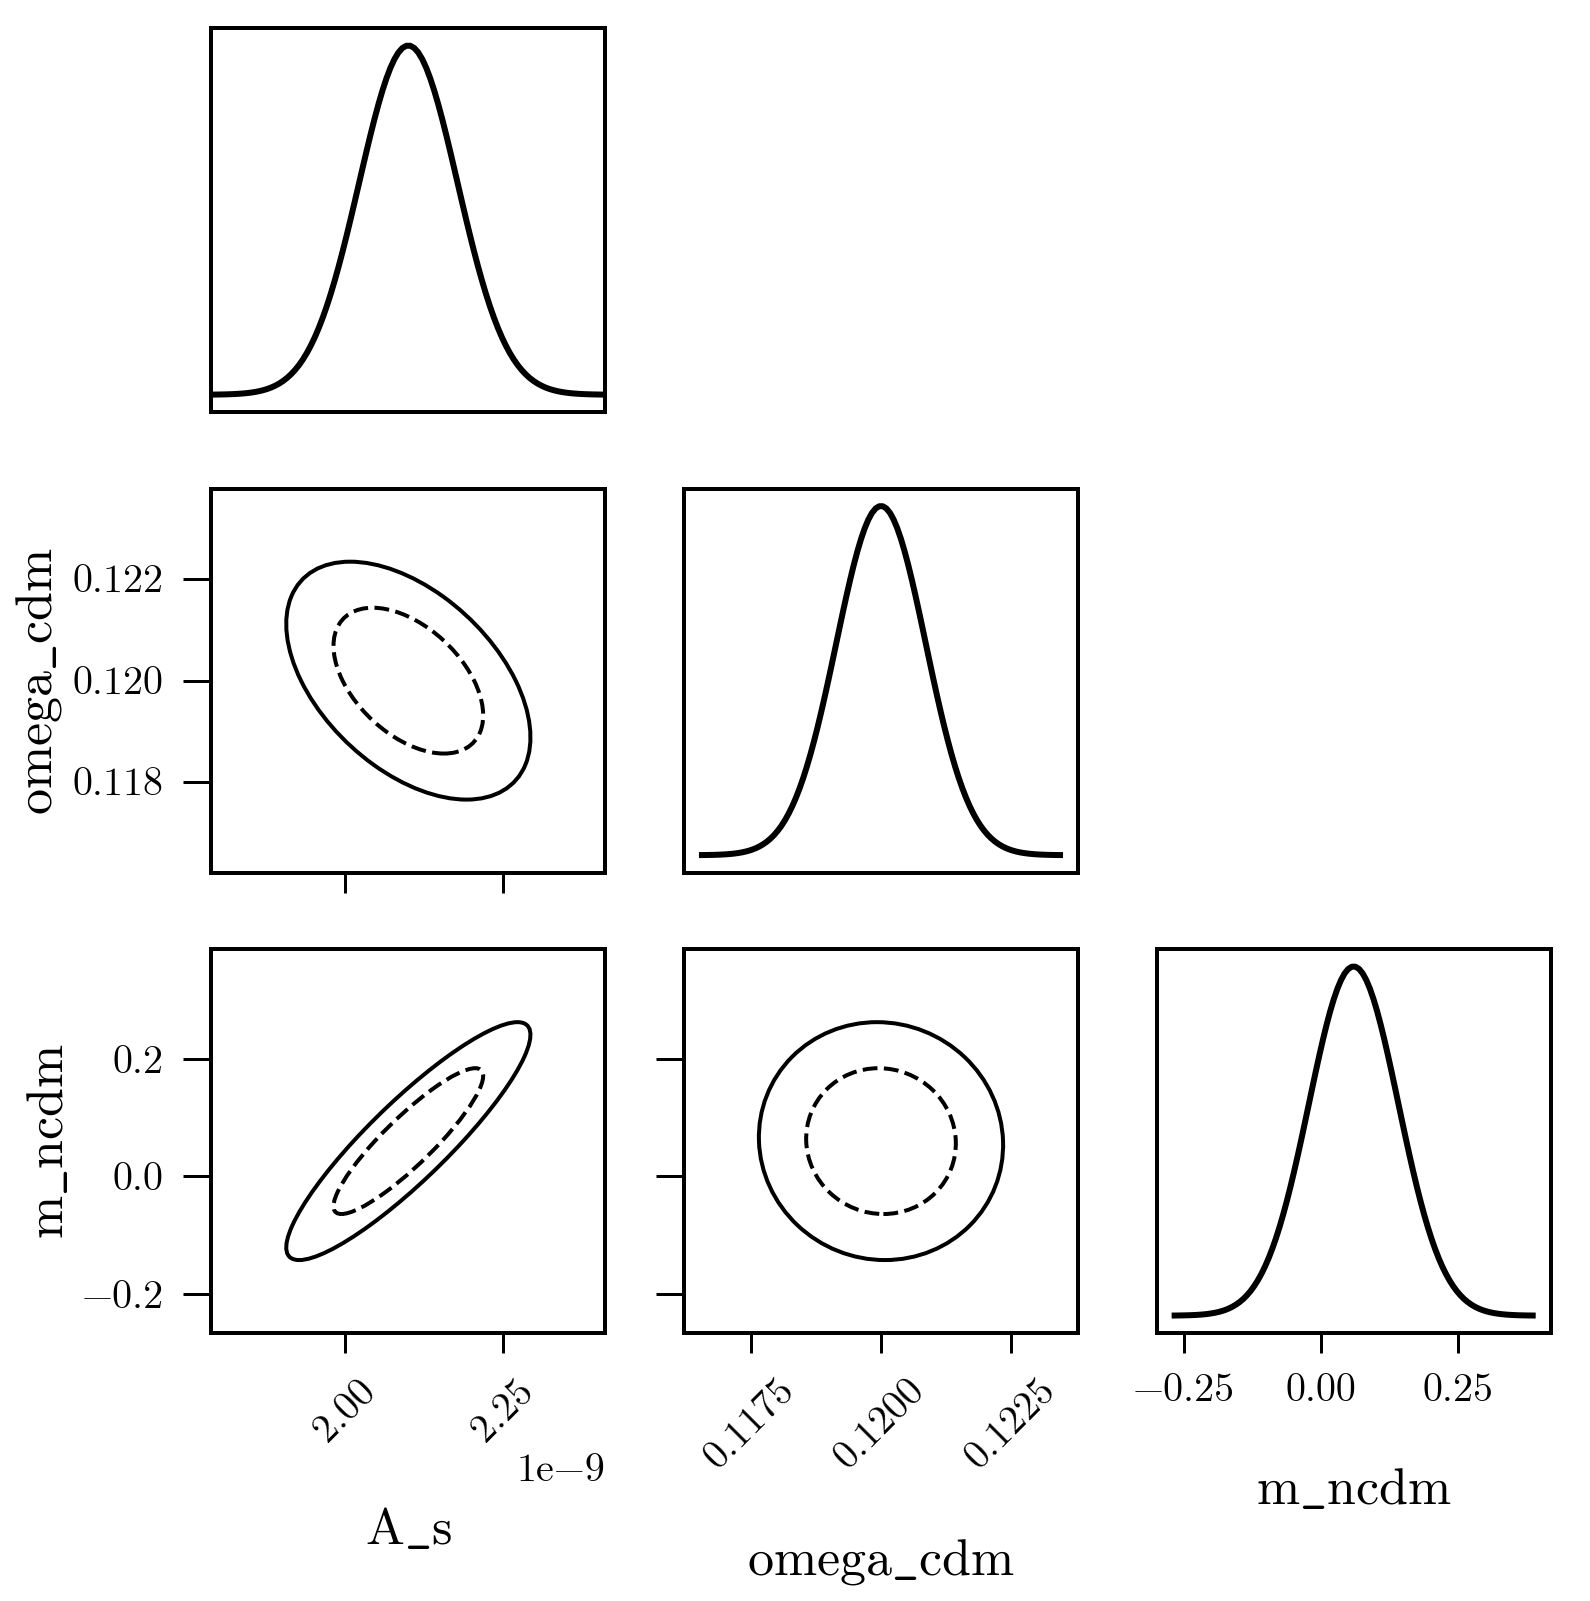

In [11]:
cov = np.linalg.inv(fisher_tom)
fishchips.util.plot_triangle(obs_tom, cov);

In [12]:
np.sqrt(cov[-1,-1])

0.08164130619213021

# Compare with Single Redshift

In [13]:
# create an Observables object to store information for derivatives
obs = Observables(parameters= ['A_s', 'omega_cdm', 'm_ncdm'],
                  fiducial=[2.1e-9, 0.12,  0.06],
                  left=[2.0e-9, 0.10, 0.0],
                  right=[2.2e-9, 0.14, 0.12])

# generate a template CLASS python wrapper configuration
classy_template = {'output': 'tCl pCl lCl sCl mPk rCl',
                   'l_max_scalars': 5000,
                   'lensing': 'yes',
                   'N_ncdm': 1,
                   'non linear': 'halofit',
                   'selection': 'dirac',
                   'selection_mean' : '1.0',
                   'l_max_lss' : 5000,
                    'accurate_lensing':1
                  }
# classy_template.update(fishchips.util.PRECISE_CLASS_DICT)
# add in the fiducial values too
classy_template.update(dict(zip(obs.parameters, obs.fiducial)))

# generate the fiducial cosmology
obs.compute_cosmo(key='CLASS_fiducial', classy_dict=classy_template)

# generate an observables dictionary, looping over parameters
for par, par_left, par_right in zip(obs.parameters, obs.left, obs.right):
    classy_left = classy_template.copy()
    classy_left[par] = par_left
    classy_right = classy_template.copy()
    classy_right[par] = par_right
    # pass the dictionaries full of configurations to get computed
    obs.compute_cosmo(key=par + '_CLASS_left', classy_dict=classy_left)
    obs.compute_cosmo(key=par + '_CLASS_right', classy_dict=classy_right)
    
import itertools

class SingleRedshiftGalaxyLensing(Experiment):
    """An experiment which has a delta function source plane."""
    
    def __init__(self, fsky, ngal, sigma_e, l_min, l_max):
        """Get the required noise properties of the experiment.
        
        Parameters
        ----------
            fsky (float) : sky fraction
            ngal (float) : number density of galaxies per steradian
            sigma_e (float) : galaxy shape noise parameter
            l_min (int) : minimum ell bin
            l_max (int) : maximum ell bin
        
        """
        self.fsky = fsky
        self.ngal = ngal
        self.sigma_e = sigma_e
        self.l_min = l_min
        self.l_max = l_max
        
    def get_Pkappa(self, cosmo, source_plane_index=0):
        """
        Extract the convergence power spectrum from a CLASS object.
        
        This utility function is required because CLASS's `ll` output
        corresponds to the lensing potential power spectrum, which must
        be converted to the lensing convergence/sheer power spectrum with 
        a factor of (ell+2)! / (ell-2)! / 4.
        
        Parameters
        ----------
            cosmo (CLASS wrapper object) : a computed CLASS cosmology
            source_plane_index (integer) : there can be multiple source
                planes, this parameter specifies which one.
        
        Returns
        -------
            numpy array : contains the convergence power spectrum 
        
        """
        cl = cosmo.density_cl()
        ell = cl['ell']
        pref = 0.25 * (ell+2) * (ell+1) * (ell) * (ell-1)
        convergencePS = pref * cl['ll'][source_plane_index]
        return convergencePS

    def get_fisher(self, obs):
        """Compute the Fisher matrix."""
        npar = len(obs.parameters)
        self.fisher = np.zeros((npar, npar))
        
        fid_kappa = self.get_Pkappa(obs.cosmos['CLASS_fiducial'])
        # compute derivatives for each parameter
        dCl = [(self.get_Pkappa(obs.cosmos[obs.parameters[i] + '_CLASS_right'])-
               self.get_Pkappa(obs.cosmos[obs.parameters[i] + '_CLASS_left']))
               /(obs.right[i] - obs.left[i]) for i in range(npar)]
        self.fisher_ell = np.zeros(self.l_max)
        
        for i, j in itertools.combinations_with_replacement(range(npar), r=2):
            # compute covariance matrix
            fisher_sum = 0.0
            for l in range(self.l_min, self.l_max):
                Cmat = np.array([[fid_kappa[l] + self.sigma_e**2/self.ngal]])
                invC = np.linalg.inv(Cmat)
                term = np.dot(np.dot(invC,dCl[i][l]),
                           np.dot(invC,dCl[j][l]))
                summand = (l+0.5) * self.fsky * np.trace(term)
                
                fisher_sum += summand
                if i == j and obs.parameters[i] == 'm_ncdm':
                    self.fisher_ell[l] += summand

            self.fisher[i, j] = fisher_sum
            self.fisher[j, i] = fisher_sum
                
        return self.fisher

Planck = CMB_Primary()
exp = SingleRedshiftGalaxyLensing(fsky=0.4, ngal=40*3437.75**2, 
                                  sigma_e=0.35, l_min=80, l_max=3000)
fisher = exp.get_fisher(obs) #+ Planck.get_fisher(obs)


In [14]:
single_cov = np.linalg.inv(fisher)

generating new axis
['$\\mathrm{A\\_s}$', '$\\mathrm{omega\\_cdm}$', '$\\mathrm{m\\_ncdm}$']
['$\\mathrm{A\\_s}$', '$\\mathrm{omega\\_cdm}$', '$\\mathrm{m\\_ncdm}$']


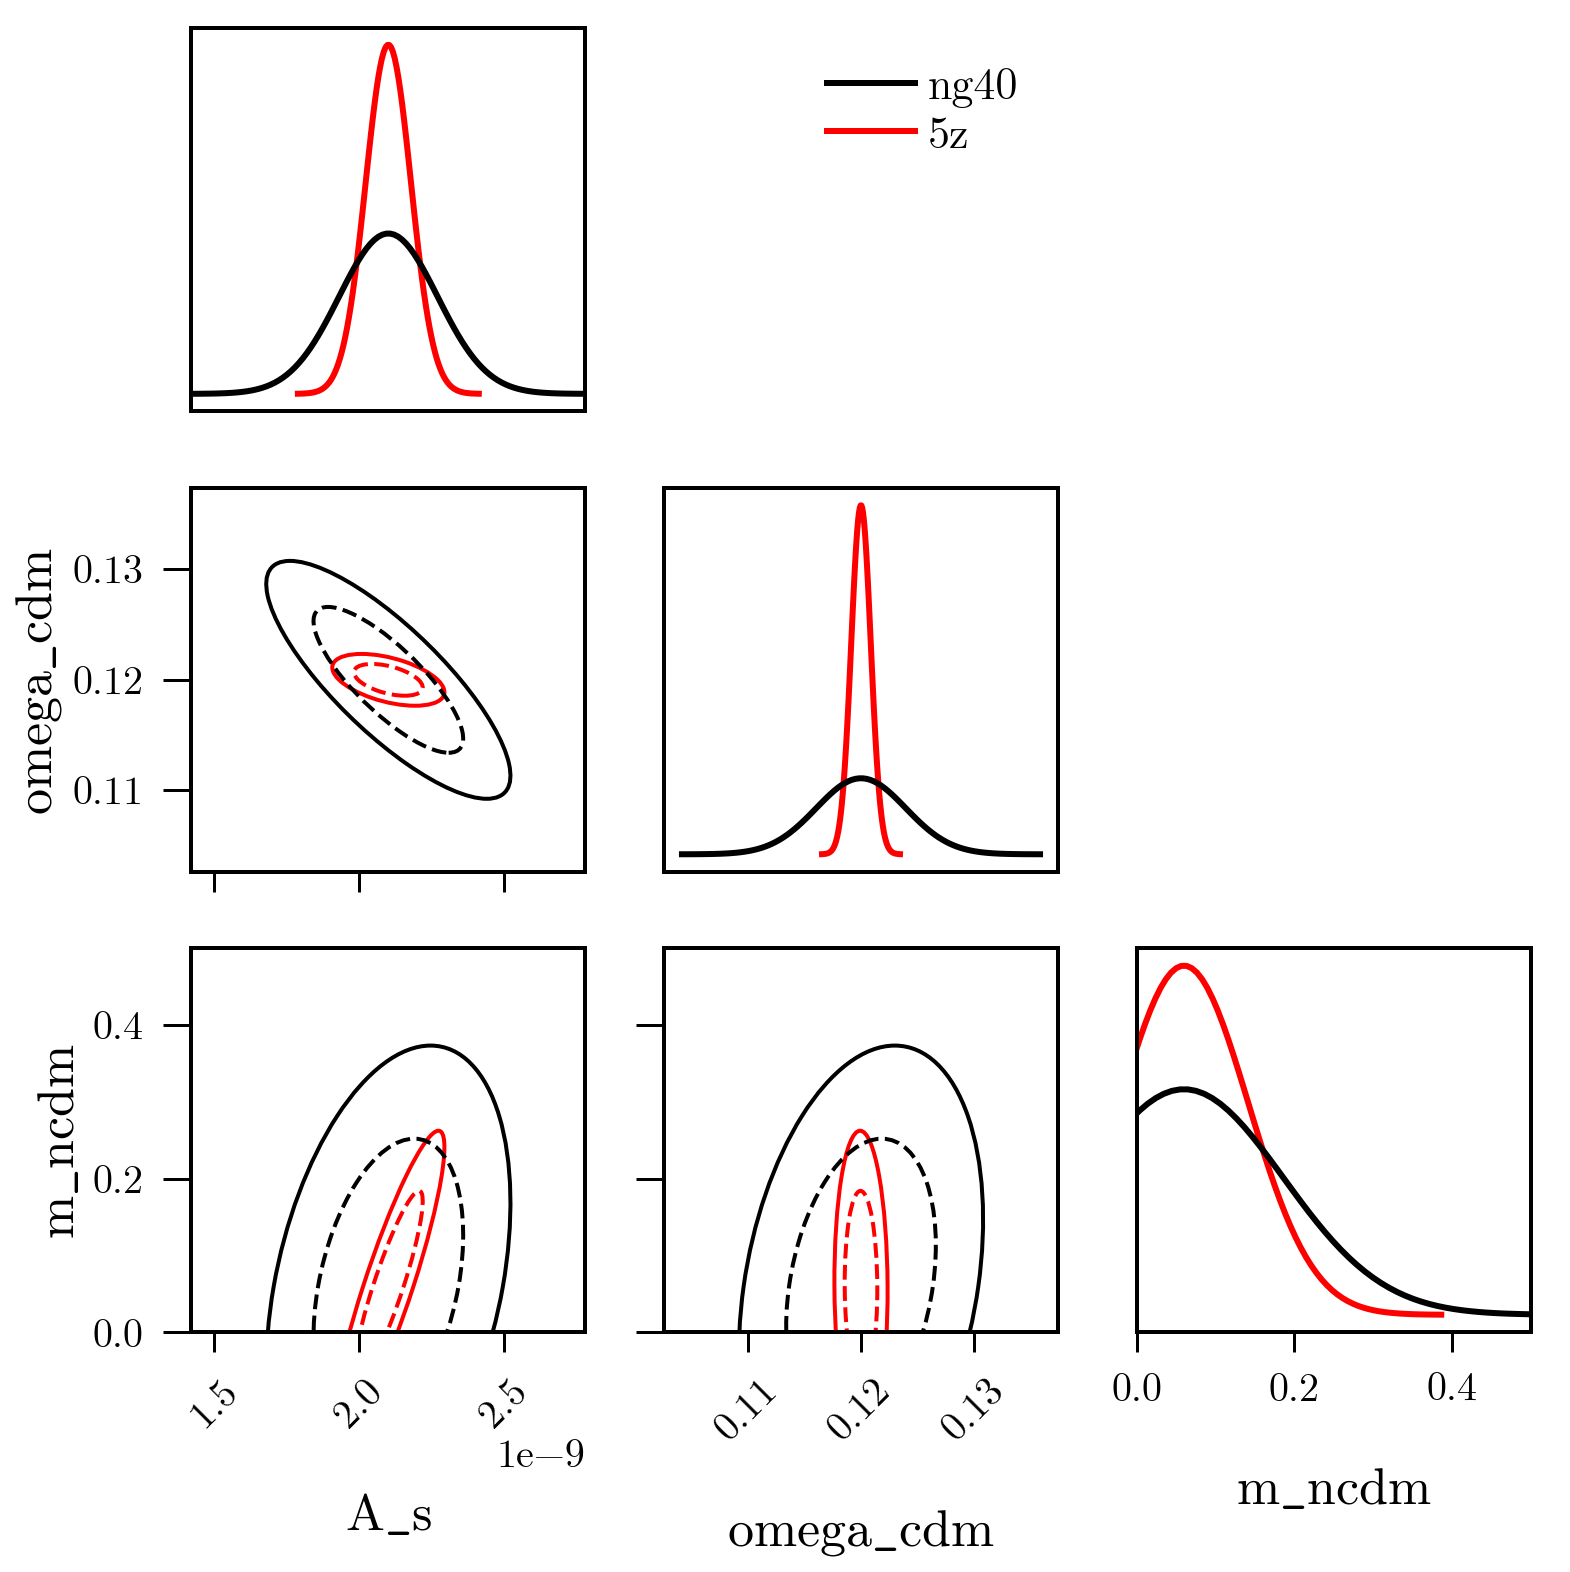

In [23]:

fig, ax = fishchips.util.plot_triangle(obs_tom, cov, color='red');
fig, ax = fishchips.util.plot_triangle(obs, single_cov, f=fig, ax=ax);
ax[-1,0].set_ylim(0,0.5)
ax[-1,1].set_ylim(0,0.5)
ax[-1,2].set_xlim(0,0.5)

ax[0,1].plot([],[],color='black',label='ng40')
ax[0,1].plot([],[],color='red',label='5z')
ax[0,1].legend()